In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Final Reported CNV Proportion

Text(0.5, 1.0, 'Reported CNV proportion at final gen (116)\n $Pr(cnv+ \\leq 0.01)$ = 0.2')

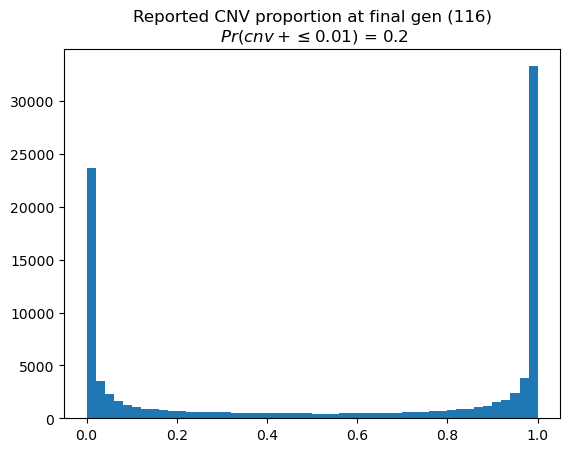

In [3]:
xs = pd.read_csv('presimulated_data/WF_presimulated_data_100000_chuong.csv')
generation=np.genfromtxt('Chuong_116_gens.txt',delimiter=',', skip_header=1,dtype="int64")

xs.columns = generation
plt.hist(xs[116], bins = 50)
plt.title(f'Reported CNV proportion at final gen (116)\n $Pr(cnv+ \\leq 0.01)$ = {round(len(xs[xs[116]<=0.01]) / len(xs),2)}')

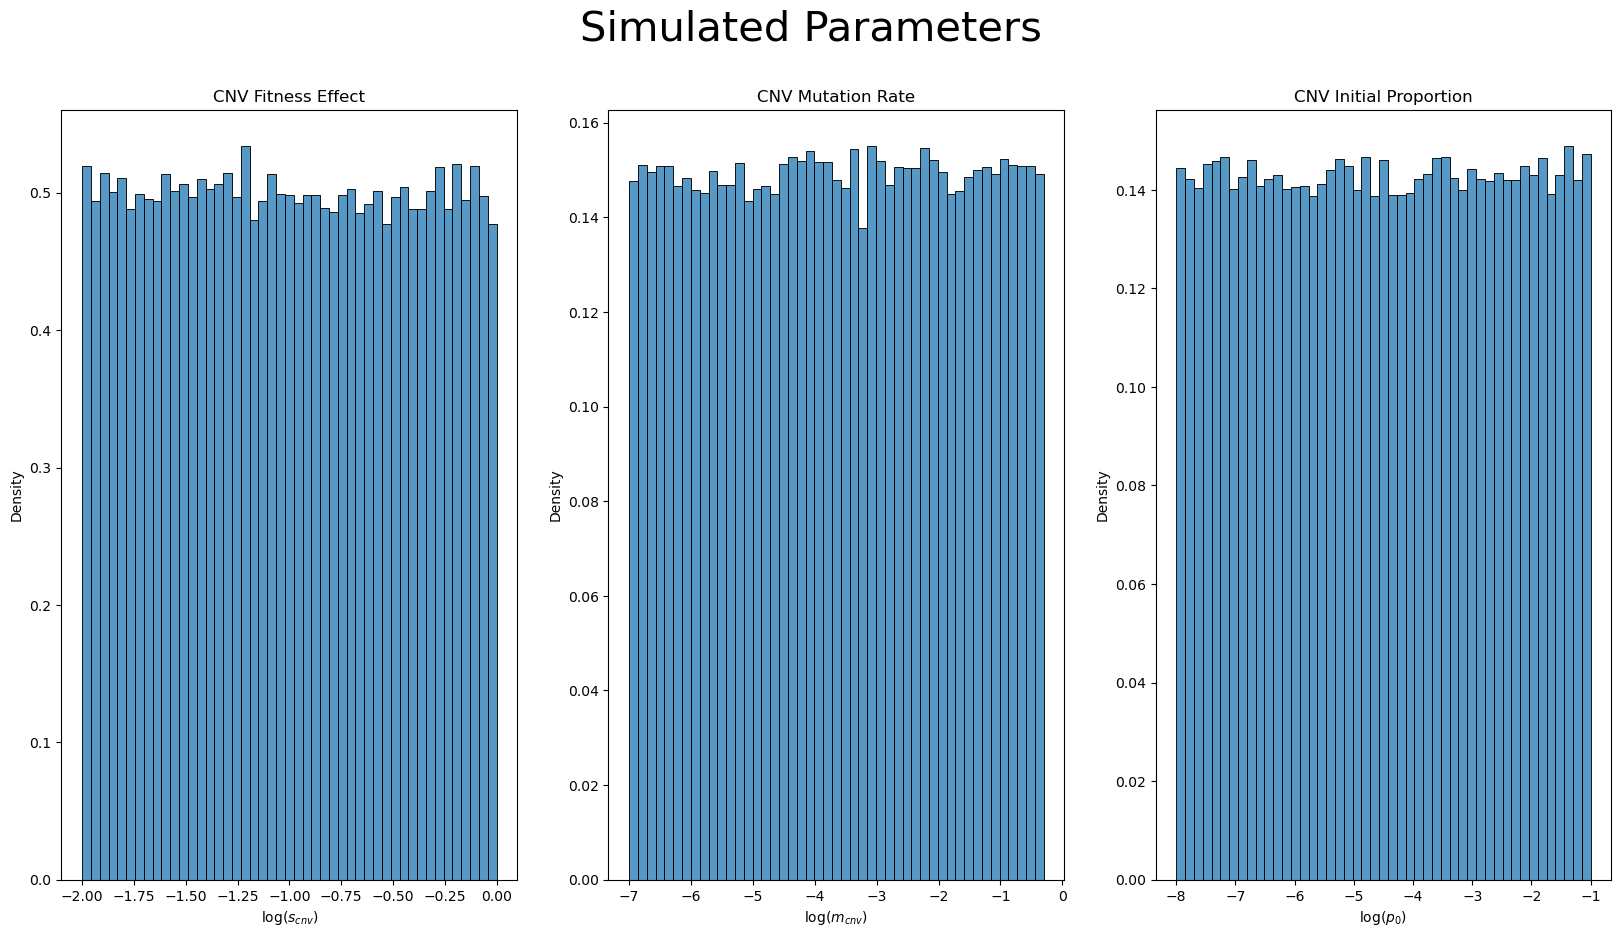

In [8]:
# Histograms of simulated parameters
from seaborn import histplot as hst

def plot_param(thetas,ax, loc, param):
    ax[loc[1]].set_xlabel(param)
    hst(thetas.iloc[:,2*loc[0]+loc[1]], ax = ax[loc[1]], fill=True, stat = 'density')


thetas = pd.read_csv('presimulated_data/WF_presimulated_theta_100000_chuong.csv')
fig, ax = plt.subplots(1,3,figsize=(20,10), sharex = False)
fig.suptitle('Simulated Parameters', fontsize = 30)
ax[0].set_title('CNV Fitness Effect')
ax[1].set_title('CNV Mutation Rate')
title_2 = 'CNV Initial Proportion'
ax[2].set_title(title_2)

plot_param(thetas, ax, (0,0), param='log($s_{cnv}$)')
plot_param(thetas, ax, (0,1), param='log($m_{cnv}$)')
param_2 = 'log($p_0$)'
plot_param(thetas, ax, (0,2), param=param_2)


# Network losses through training

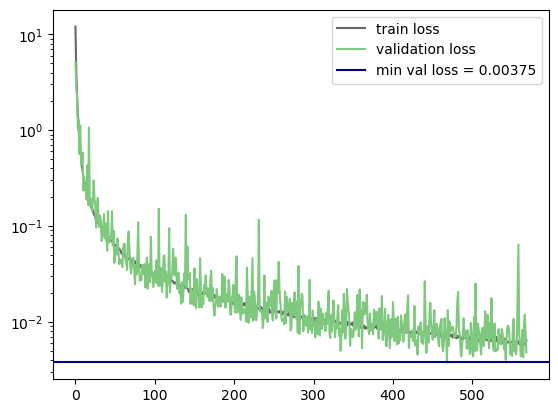

In [9]:
losses_100 = pd.read_csv('losses/losses_100_epochs_chuong.csv')
losses_100 = np.e**(-1*losses_100)
minloss_100 = losses_100['validation loss'].min()
losses_100.plot(colormap = 'Accent_r')
plt.axhline(minloss_100, label = f'min val loss = {round(minloss_100,5)}', color = 'navy')
plt.legend()
plt.yscale('log')

# Synthetic Validations

## Get MAP estimations for 1,000 simulations

In [3]:
%%capture

# Get simulations
sims = pd.read_csv('synthetic_tests/WF_presimulated_data_1000_test.csv', header=None)
sims.columns=pd.read_csv('empirical_data/clean/wt.csv', index_col=0).columns.tolist()
sims.index = [i for i in range(len(sims))]
thetas = pd.read_csv('synthetic_tests/WF_presimulated_theta_1000_test.csv', header=None)
params = ['$log(s_C)$','$log(δ_C)$','$log(p_0)$']

# Infer simulations
def infer_on_sims(sims, thetas, posterior):
    inferred_df = pd.DataFrame(index = sims.index, columns = params+["est_"+param for param in params]+["ratio_"+param for param in params])

    for i in range(len(sims)):
        est = posterior_chuong.set_default_x(sims.iloc[i,:]).map(num_init_samples=100, num_iter=80)
        inferred_df.iloc[i,0:3] = thetas.iloc[i,:]
        inferred_df.iloc[i,3:6] = est
        inferred_df.iloc[i,6:] = np.log(est / thetas.iloc[i,:])

    inferred_df.to_csv('inferred_sims_results.csv')
    return inferred_df

# Previously generated simulations
# inferred_df = infer_on_sims(sims, thetas, posterior_chuong)
inferred_df = pd.read_csv('inferred_sims_results.csv', index_col=0)


## Plot $log_{10}(MAP/True)$ for all Parameters

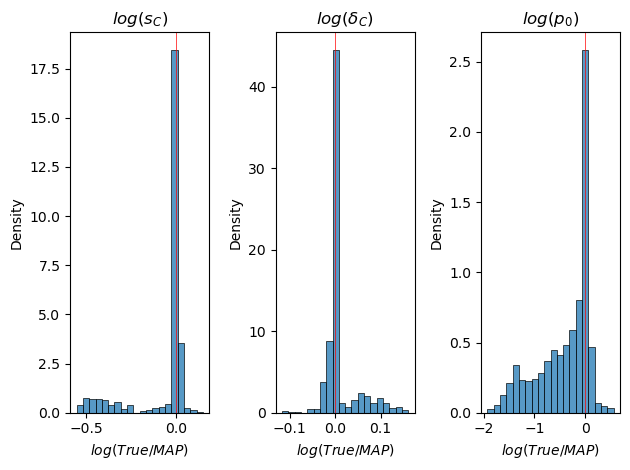

In [4]:
from seaborn import histplot
fig, ax = plt.subplots(1,3, tight_layout = True)

for k in range(3):
    histplot(ax=ax[k], x=inferred_df.iloc[:,k-3], label = 'MAP error ratio', stat='density', bins=20)
    ax[k].axvline(0, color = 'red', label = '0', linewidth=0.5)
    ax[k].set_title(params[k])
    ax[k].set_xlabel('$log(True / MAP)$')

## Coverage ( $P(true$ $parameter \in 95\% $ $HDI)$ )

In [5]:
%%capture

# Get simulations

sims = pd.read_csv('synthetic_tests/WF_presimulated_data_1000_test.csv', header=None)
sims.columns=read_empirical('wt', clean=True).columns.tolist()
sims.index = [i for i in range(len(sims))]
thetas = pd.read_csv('synthetic_tests/WF_presimulated_theta_1000_test.csv', header=None)

params = ['$log(s_C)$','$log(δ_C)$','$log(p_0)$']
    
def covered(param, samples, acc=0.95):
    return 

coverage = pd.DataFrame(columns=['coverage'], index = params, dtype='float')
coverage = coverage.fillna(0)

for i in range(len(sims)):
    samples = posterior_chuong.set_default_x(sims.iloc[i,:]).sample((100,))
    if i%100 ==0:
        print(i)
    for j in range(len(params)//100):
        covered = int(min( samples.quantile((1-acc)/2) < param , param < samples.quantile((1-(1-acc)/2)) ))
        coverage.loc[params[j], 'coverage'] += covered
        
coverage = coverage / len(sims)

In [45]:
coverage

,coverage
$log(s_C)$,0.976
$log(δ_C)$,0.998
$log(p_0)$,0.907
